In [1]:
# In this example, first a single plane lens is created with four NSIE profiles,
# inspired by the lensing scenario in Abell 3827. Then, the galaxies are split
# over two lensplanes: one in a lens plane slightly in front of the plane containing
# the other three galaxies. If the NSIE parameters are unchanged, this changes
# the lensing result, causing images no longer to correspond nicely to a single
# source shape. But making very minor changes to the NSIE positions and weights
# can make the same source produce nearly identical images.

In [2]:
%matplotlib inline
from grale.all_nb import *
import pickle

z_lens = 0.099
z_s1 = 1.241
cosm = cosmology.Cosmology(0.7, 0.3, 0, 0.7)
cosmology.setDefaultCosmology(cosm)
D = cosm.getAngularDiameterDistance

slPlotWidth = 40*ANGLE_ARCSEC

Set 'threads' as default renderer for lensplane and mass density
Set default angular unit in plotting to arcsec
Set feedback style to 'notebook'


In [3]:
feedback.setDefaultFeedback("none")

In [4]:
# Create a single plane lens based on the following NSIE positions and parameters
centerOfLightN1 = V(5.1389537749905205, -1.9832135503591473) * ANGLE_ARCSEC
centerOfLightN2 = V(-0.015864304616332744, 0.009518582769799647) * ANGLE_ARCSEC
centerOfLightN3 = V(-4.61312335992868,1.9637988828299742) * ANGLE_ARCSEC
centerOfLightN4 = V(-4.163588705048222,-3.087628627423895) * ANGLE_ARCSEC

vDisp = 300000
core = 0.2*ANGLE_ARCSEC
ell = 0.7

centers = [ centerOfLightN1, centerOfLightN2, centerOfLightN3, centerOfLightN4 ]
splaneLens = lenses.CompositeLens(D(z_lens), [
    { "x": c[0], "y": c[1], "angle": 30, "factor": 1, "lens": lenses.NSIELens(D(z_lens), { "velocityDispersion": vDisp, "coreRadius": core, "ellipticity": ell}) } for c in centers
])

In [5]:
li = plotutil.LensInfo(splaneLens, size=slPlotWidth, zd=z_lens, zs=z_s1, numxy=2047)

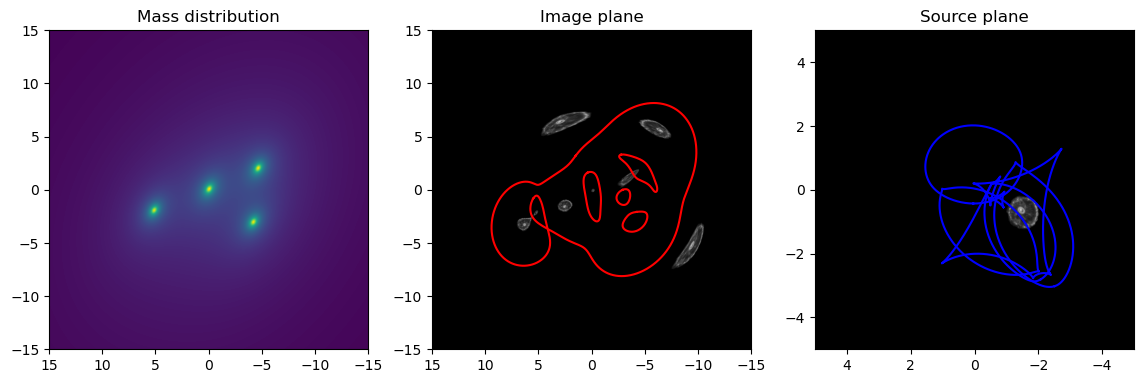

In [6]:
bulgePos = V(-1.5,-0.75)*ANGLE_ARCSEC

# Simple disc as source shape
# src = images.CircularSource(bulgePos, 0.5*ANGLE_ARCSEC)

# Source shape based on image of Cartwheel galaxy
pngPix = plt.imread("ringgalaxy-gray.png")[:,:,0].astype(np.double)
src = images.DiscreteSource(pngPix, 1.1*ANGLE_ARCSEC, 1.1*ANGLE_ARCSEC, bulgePos)

plt.figure(figsize=(14,7))
plt.subplot(1,3,1)
plotutil.plotDensity(li)
plt.gca().set_xlim(left=15, right=-15)
plt.gca().set_ylim(top=15, bottom=-15)
plt.title("Mass distribution")

plt.subplot(1,3,2)
plotutil.plotImagePlane(li,sources=[{"shape": src, "z": z_s1}], plotCaustics=False, plotSources=False)
plt.gca().set_xlim(left=15, right=-15)
plt.gca().set_ylim(top=15, bottom=-15)
plt.title("Image plane")

plt.subplot(1,3,3)
plotutil.plotImagePlane(li,sources=[{"shape": src, "z": z_s1}], plotCriticalLines=False, plotImages=False, sourceRgb=(1,1,1))
plt.gca().set_xlim(left=5, right=-5)
plt.gca().set_ylim(top=5, bottom=-5)
plt.title("Source plane");

In [7]:
# Create some fake point based measurements. We'll assume we can measure the
# central position (only roughly the center in the galaxy shape image used, but
# that's not important) as well as a number of positions along the ring itself.
outerPos = [ V(bulgePos[0] + 0.5*ANGLE_ARCSEC * np.cos(a), bulgePos[1] + 0.5*ANGLE_ARCSEC * np.sin(a)) for a in np.linspace(0, 2*np.pi, 9)[:-1]]

In [8]:
# Trace the positions above, to base some fake measurements on
#
#for pos in [ bulgePos ] + outerPos:
#    tracedPos = np.array(li.getImagePlane().traceBeta(pos))/ANGLE_ARCSEC
#    for t in tracedPos:
#        print(t[0], t[1])
#    print()

In [9]:
# Filtered some images, keeping only five
fakePos = """
-9.312556620030337 -5.559149497283721
6.410157271448218 -3.2599804559517636
#5.190233504827413 -2.146593721158564
2.5709825763232503 -1.5227190088862614
#-0.08415564121875471 -0.10488220376557042
-6.11519440950453 5.591410858774934
2.8751235484167057 6.20920947888814

-7.859520164503608 -6.6598836693062085
6.5437888502969805 -3.912600411071867
#5.054039889057457 -2.1188445627059465
3.1767276530324082 -1.837220355896864
#-0.2542755602164313 -0.09630673608751449
#-2.658699554751371 0.19841718250640747
#-4.394076120895495 1.7136744530125743
-6.758395138696659 4.740240014231346
4.680341899217227 5.586285870893887

-9.198887887419588 -4.693462875517281
6.044350059663207 -3.6968407011997235
#5.113191576781907 -2.2607126652171066
2.766163377162115 -2.0887757429285214
#-0.19584008581810675 -0.21797247991734658
-7.269683562933282 4.846308104631694
3.7884275548712503 6.441944494482838

-10.07100017252906 -3.3741317443925998
5.774506497356467 -3.1247987846187932
#5.265304572309842 -2.4046864152174523
2.1783816511976397 -1.9425850887768694
#-0.07122029555220614 -0.2763912887154811
-7.105329837331146 5.497200080152699
2.309961655873778 7.067659629039688

-10.426376982059583 -3.6525202311899787
5.706397722562774 -2.7182043752182654
#5.436581010247475 -2.435023269639169
1.8771402309087877 -1.5086581213399919
#0.025800277143792048 -0.23429203188150163
-5.924154483003793 6.324845221782165
0.7367533722539324 7.19104241016919

-10.258496332960911 -4.847722219282053
6.033041579589553 -2.7012994818170584
#5.37440023923525 -2.2208154794734383
1.997329444743509 -1.1604737220863213
#0.040367945960936236 -0.12796576088759914
-4.567385532285473 6.493233731924094
0.08420618921371384 6.814895674348099

-9.523449876070424 -6.198821051796571
6.523221340824832 -2.744890107171736
#5.261491326110584 -2.067939174913807
2.4112009169124686 -1.0084157225866741
#-0.01309890197199051 -0.0289601176769588
-4.627579829921681 5.977757545243394
1.589299357724559 6.037272834420022

-8.432538512389266 -7.184389161336651
6.956343133819088 -2.9564095360031
#5.158019595121503 -2.0054497355846634
2.9006319390649513 -1.1284834613515233
#-0.10360774152234169 0.022128775375569194
#-3.0844499575358677 1.1878630689800989
#-4.236723713567958 1.831437553889246
3.572100941479273 5.192977214280357
-5.345772787061545 5.370200195088657

-7.554523989556526 -7.460405336801707
7.00173879074029 -3.4997538554017646
#5.079085547294476 -2.0246026304143627
3.204475734266992 -1.465125418595473
#-0.2033227511295307 0.0021319132766926792
#-2.47230859418254 0.5879699210158936
#-4.399458656809604 1.8395656615373965
-6.067002332924662 4.946166070152192
4.666757758031531 5.009814269735521
"""
imgDat = images.readInputImagesFile(fakePos, True)

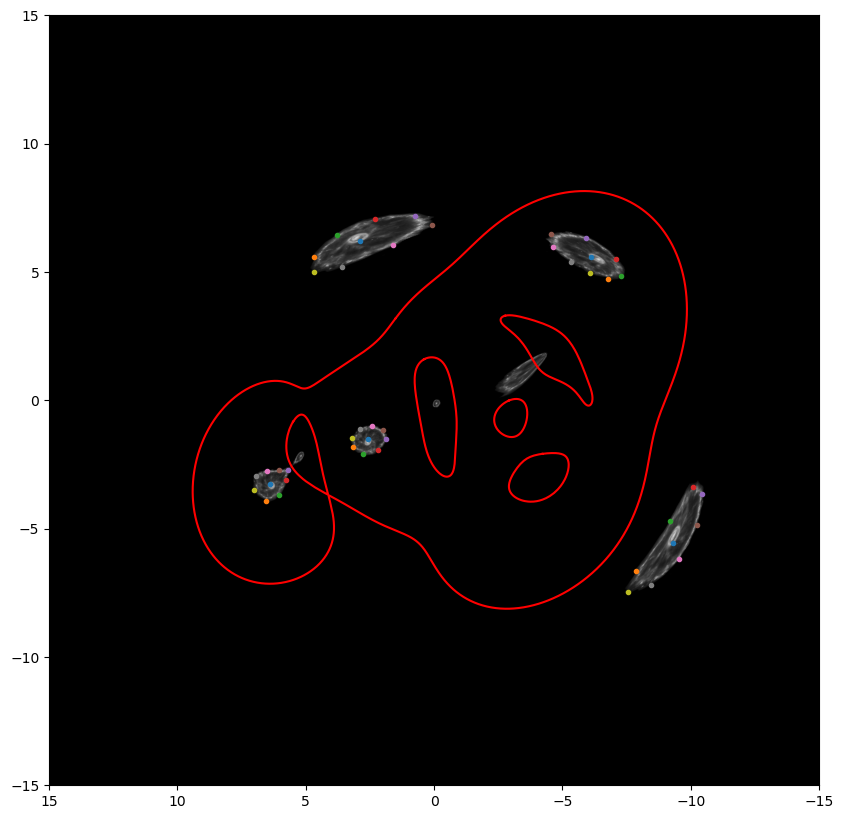

In [10]:
# Plot the image plane again, together with these fake observations
plt.figure(figsize=(10,10))
plotutil.plotImagePlane(li,sources=[{"shape": src, "z": z_s1}], plotCaustics=False, plotSources=False)
plt.gca().set_xlim(left=15, right=-15)
plt.gca().set_ylim(top=15, bottom=-15)
plotutil.plotImagesData(imgDat)

In [11]:
# We'll use an inversion workspace to backproject these fake measurements
# as well as to calculate how well the backprojected points overlap (like
# in the inversion algorithm itself)
iws = inversion.InversionWorkSpace(z_lens, slPlotWidth)
for i in imgDat:
    iws.addImageDataToList(i["imgdata"], z_s1, "pointimages")

In [12]:
# Now we'll create a different lens, where one NSIE is slightly before the others.
# The difference in redshift was chosen so that the angular diameter distance was
# approximately
dz = -0.0118
print("Diff in lensplane distance: ",(D(z_lens) - D(z_lens+dz))/DIST_MPC, "Mpc")

bgLens = lenses.CompositeLens(D(z_lens), [
        { "x": c[0], "y": c[1], "angle": 30, "factor": 1, "lens": lenses.NSIELens(D(z_lens), { "velocityDispersion": vDisp, "coreRadius": core, "ellipticity": ell}) } for c in centers[:3]
    ])

fgLens = lenses.CompositeLens(D(z_lens + dz), [
        { "x": c[0], "y": c[1], "angle": 30, "factor": 1, "lens": lenses.NSIELens(D(z_lens + dz), { "velocityDispersion": vDisp, "coreRadius": core, "ellipticity": ell}) } for c in centers[3:]
    ])

mplLens = lenses.MultiPlaneContainer(0,
        [
            { "lens": fgLens, "z": z_lens+dz },
            { "lens": bgLens, "z": z_lens}
        ])

Diff in lensplane distance:  40.393070336000044 Mpc


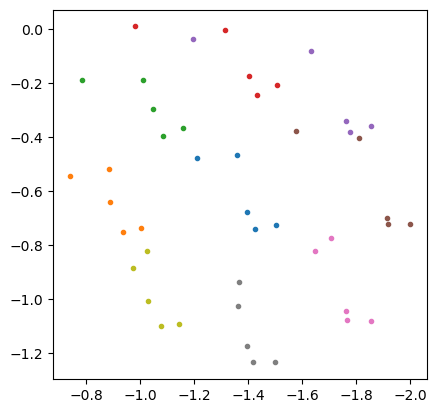

In [13]:
# Since we changed the lens itself somewhat, it won't come as a surprise that when
# backprojecting the fake measurements with this modified lens, the backprojected
# points no longer overlap nicely.
plotutil.plotImagesData(iws.backProject(mplLens))
plt.gca().set_aspect("equal")
plt.gca().invert_xaxis()

In [14]:
# We're going to adjust the NSIE scales and positions slightly, to see if we
# can make some small adjustments so that the backprojected points overlap better
# again. The galaxies are still split over the two lens planes.
def calcFitness(offsetsAndScales, outputModel=False, printFitness=True):
    
    assert(len(offsetsAndScales) == 12)
    
    bgParams = []
    for i in range(3):
        dx, dy, df = offsetsAndScales[i*3:(i+1)*3]
        cx, cy = centers[i]
        bgParams.append(
            { "x": cx + dx*ANGLE_ARCSEC, "y": cy+dy*ANGLE_ARCSEC, "angle": 30, "factor": 1+df, 
             "lens": lenses.NSIELens(D(z_lens), { "velocityDispersion": vDisp, "coreRadius": core, "ellipticity": ell}) }
        )
        
    bgLens = lenses.CompositeLens(D(z_lens), bgParams)

    dx, dy, df = offsetsAndScales[3*3:]
    cx, cy = centers[-1]
    fgLens = lenses.CompositeLens(D(z_lens + dz), [
        { "x": cx+dx*ANGLE_ARCSEC, "y": cy+dy*ANGLE_ARCSEC, "angle": 30, "factor": 1+df,
          "lens": lenses.NSIELens(D(z_lens + dz), { "velocityDispersion": vDisp, "coreRadius": core, "ellipticity": ell}) }
    ])

    mplLens = lenses.MultiPlaneContainer(0,
        [
            { "lens": fgLens, "z": z_lens+dz },
            { "lens": bgLens, "z": z_lens}
        ])
    
    fit = iws.calculateFitness(mplLens)[0][0]
    if printFitness:
        print(fit)

    if not outputModel:
        return fit
    return fit, mplLens

In [15]:
# This is the result of an optimization, using scipy.optimize.minimize, with the calcFitness objective
# function from above, using the Nelder-Mead method, and starting from x0 = np.zeros((12,))
import pickle
fitDiffParams = pickle.load(open("a3827like-lensparamsadjustments_40Mpc.pickle", "rb"))

In [16]:
# Get a model that incorporates these small changes
fitValue, optModel = calcFitness(fitDiffParams, outputModel=True, printFitness=False)

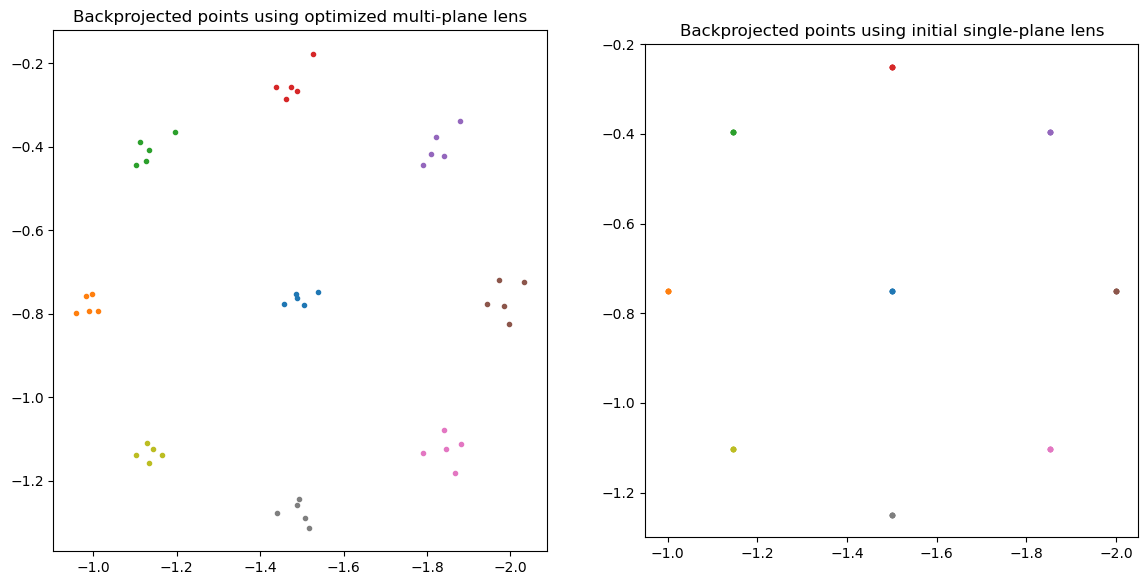

In [17]:
# If this is used to backproject the observations again, they now coincide
# quite nicely in the source plane. For reference, the backprojected points
# using the initial, single plane lens are shown as well. Note that while in
# principle it could be the case that the optimization procedure would have
# moved the points in the source plane, this turns out not to be the case.
# This then suggests that we can use the exact same source shape as well to
# calculate the images of the new situation.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plotutil.plotImagesData(iws.backProject(optModel))
plt.gca().set_aspect("equal")
plt.gca().invert_xaxis()
plt.title("Backprojected points using optimized multi-plane lens")
plt.subplot(1,2,2)
plotutil.plotImagesData(iws.backProject(splaneLens))
plt.gca().set_aspect("equal")
plt.gca().invert_xaxis()
plt.title("Backprojected points using initial single-plane lens");

In [18]:
# Prepare to plot the image plane of the combined lens, as well as the mass
# densities for foreground and background lens planes
li2 = plotutil.LensInfo(optModel, size=slPlotWidth, zs=z_s1, numxy=2047)

fgOptModel = optModel.getLensParameters()[0]["lens"]
fgZ = optModel.getLensParameters()[0]["z"]
bgOptModel = optModel.getLensParameters()[1]["lens"]
bgZ = optModel.getLensParameters()[1]["z"]

liFg = plotutil.LensInfo(fgOptModel, size=slPlotWidth, zs=z_s1, zd=fgZ, numxy=2047)
liBg = plotutil.LensInfo(bgOptModel, size=slPlotWidth, zs=z_s1, zd=bgZ, numxy=2047)

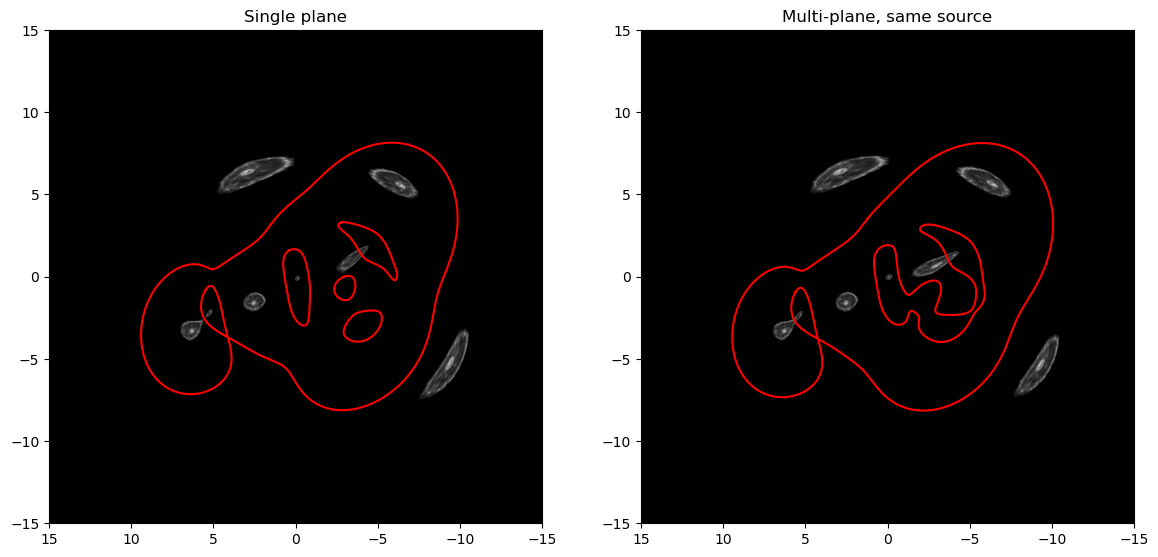

In [19]:
# Here, for the exact same source shape and position, we generate the images for both
# the single plane lensing situations and multi-plane one. They look identical.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plotutil.plotImagePlane(li,sources=[{"shape": src, "z": z_s1}], plotCaustics=False, plotSources=False)
plt.gca().set_xlim(left=15, right=-15)
plt.gca().set_ylim(top=15, bottom=-15)
plt.title(f"Single plane")

plt.subplot(1,2,2)
plotutil.plotImagePlane(li2,sources=[{"shape": src, "z": z_s1}], plotCaustics=False, plotSources=False)
plt.gca().set_xlim(left=15, right=-15)
plt.gca().set_ylim(top=15, bottom=-15)
plt.title(f"Multi-plane, same source");

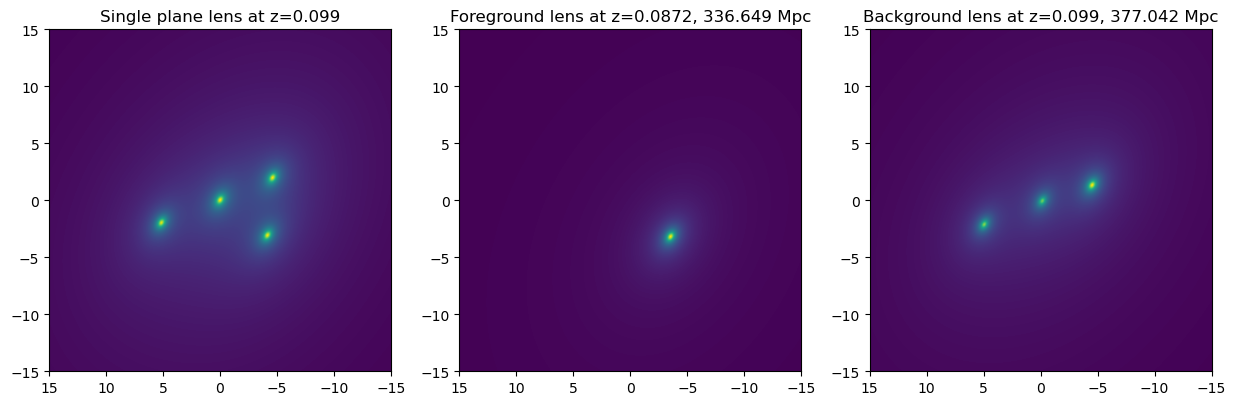

In [20]:
# Let's also compare the mass densities. For the multi-plane lens we need to plot the mass density
# of each plane separately (in principle one plane could affect how the density of the other looks,
# and it's not clear if/how we want to take that into account)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plotutil.plotDensity(li)
plt.gca().set_xlim(left=15, right=-15)
plt.gca().set_ylim(top=15, bottom=-15)
plt.title(f"Single plane lens at z={z_lens}")

plt.subplot(1,3,2)
plotutil.plotDensity(liFg)
plt.gca().set_xlim(left=15, right=-15)
plt.gca().set_ylim(top=15, bottom=-15)
plt.title(f"Foreground lens at z={fgZ}, {D(fgZ)/DIST_MPC:g} Mpc")

plt.subplot(1,3,3)
plotutil.plotDensity(liBg)
plt.title(f"Background lens at z={bgZ}, {D(bgZ)/DIST_MPC:g} Mpc")
plt.gca().set_xlim(left=15, right=-15)
plt.gca().set_ylim(top=15, bottom=-15);

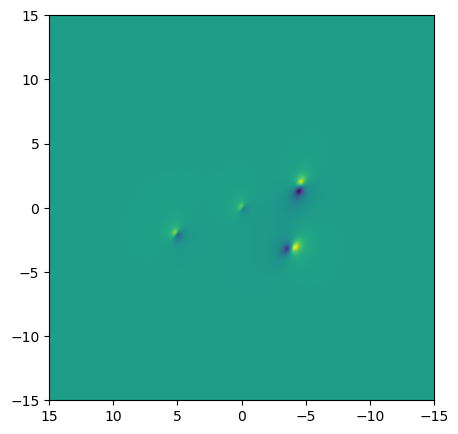

In [21]:
# Let's also plot the difference between these densities, to illustrate that
# some changes were indeed made.
diff = plotutil.DensInfo(li.getDensityPoints() - liFg.getDensityPoints() - liBg.getDensityPoints(), 
                         **li.getArea())

plt.figure(figsize=(5,5))
plotutil.plotDensity(diff)
plt.gca().set_xlim(left=15, right=-15)
plt.gca().set_ylim(top=15, bottom=-15)
plt.show()

plotutil.plotDensityInteractive(diff);